# Sentinel-2 Optical Analysis

**Study Area:** Gangotri Glacier, Uttarakhand Himalayas (30.92°N, 79.08°E)  
**Buffer:** 15km radius  
**Period:** 2018-2023  
**Analysis:** NDVI, NDSI, and spectral indices for glacier mapping

In [1]:
import ee
import geemap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
import pickle
import os
warnings.filterwarnings('ignore')
np.random.seed(42)

try:
    ee.Initialize()
    print("Earth Engine already initialized!")
except:
    ee.Authenticate()
    ee.Initialize()
    print("Earth Engine initialized successfully!")

Earth Engine already initialized!


In [2]:
# Gangotri Glacier coordinates
lon, lat = 79.08, 30.92
roi = ee.Geometry.Point([lon, lat]).buffer(15000)

print(f"Study Area: Gangotri Glacier, Uttarakhand ({lat}°N, {lon}°E)")


Study Area: Gangotri Glacier, Uttarakhand (30.92°N, 79.08°E)


In [3]:
# Visualize the study area
Map_area = geemap.Map()
Map_area.centerObject(roi, 11)
Map_area.addLayer(roi, {'color': 'yellow'}, 'Study Area (15km buffer)')
Map_area.addLayer(ee.Geometry.Point([lon, lat]), {'color': 'red'}, 'Gangotri Glacier Center')
Map_area.addLayerControl()
Map_area

Map(center=[30.92001538827935, 79.08000049742996], controls=(WidgetControl(options=['position', 'transparent_b…

In [4]:
# Load Sentinel-2 data - use broader time ranges for better coverage
col_period1 = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
            .filterBounds(roi)
            .filterDate('2018-01-01', '2019-12-31')  # 2018-2019 for more images
            .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 80))
            .select(['B3', 'B4', 'B8', 'B11']))

col_period2 = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
            .filterBounds(roi)
            .filterDate('2022-01-01', '2023-12-31')  # 2022-2023 for more images
            .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 80))
            .select(['B3', 'B4', 'B8', 'B11']))

count_p1 = col_period1.size().getInfo()
count_p2 = col_period2.size().getInfo()

print(f"Period 1 (2018-2019): {count_p1} images")
print(f"Period 2 (2022-2023): {count_p2} images")

if count_p1 == 0 or count_p2 == 0:
    raise ValueError(f"Insufficient data: Period1={count_p1}, Period2={count_p2}. Cannot proceed.")

s2_2018 = col_period1.median().clip(roi).divide(10000)
s2_2023 = col_period2.median().clip(roi).divide(10000)

print("✓ Sentinel-2 Harmonized data loaded (2018-2019 vs 2022-2023)")


Period 1 (2018-2019): 221 images
Period 2 (2022-2023): 505 images
✓ Sentinel-2 Harmonized data loaded (2018-2019 vs 2022-2023)


In [5]:
ndvi_2018 = s2_2018.normalizedDifference(['B8', 'B4']).rename('NDVI_2018')
ndvi_2023 = s2_2023.normalizedDifference(['B8', 'B4']).rename('NDVI_2023')

ndsi_2018 = s2_2018.normalizedDifference(['B3', 'B11']).rename('NDSI_2018')
ndsi_2023 = s2_2023.normalizedDifference(['B3', 'B11']).rename('NDSI_2023')

ndvi_change = ndvi_2023.subtract(ndvi_2018).rename('NDVI_change')
ndsi_change = ndsi_2023.subtract(ndsi_2018).rename('NDSI_change')

stack = ndvi_2018.addBands(ndvi_2023).addBands(ndsi_2018).addBands(ndsi_2023).addBands(ndvi_change).addBands(ndsi_change)

print("Spectral indices calculated: NDVI, NDSI, and changes")


Spectral indices calculated: NDVI, NDSI, and changes


In [6]:
Map = geemap.Map(center=[lat, lon], zoom=11)

vis_ndvi = {'min': -0.2, 'max': 0.8, 'palette': ['brown', 'yellow', 'green', 'darkgreen']}
vis_ndsi = {'min': -0.5, 'max': 0.9, 'palette': ['brown', 'white', 'blue', 'cyan']}
vis_change = {'min': -0.3, 'max': 0.3, 'palette': ['red', 'white', 'blue']}

Map.addLayer(ndvi_2018, vis_ndvi, 'NDVI 2018', False)
Map.addLayer(ndvi_2023, vis_ndvi, 'NDVI 2023', False)
Map.addLayer(ndsi_2018, vis_ndsi, 'NDSI 2018', False)
Map.addLayer(ndsi_2023, vis_ndsi, 'NDSI 2023', True)
Map.addLayer(ndsi_change, vis_change, 'NDSI Change', False)
Map.addLayer(roi, {'color': 'yellow', 'width': 2}, 'Study Area')

Map


Map(center=[30.92, 79.08], controls=(WidgetControl(options=['position', 'transparent_bg'], position='topright'…

In [7]:
# Sample with reduced pixels and coarser scale to avoid memory limit
print("Sampling data (this may take a minute)...")
sample = stack.sample(
    region=roi, 
    scale=50,  # Increased from 30m to 50m (coarser resolution)
    numPixels=300,  # Further reduced to 300
    seed=42
).getInfo()

data = []
for feature in sample['features']:
    data.append(feature['properties'])

df = pd.DataFrame(data)
print(f"Extracted {df.shape[0]} samples")


Sampling data (this may take a minute)...
Extracted 300 samples
Extracted 300 samples


In [8]:
df_clean = df.dropna()

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df_clean['class'] = kmeans.fit_predict(df_clean)

print(f"Class distribution: {df_clean['class'].value_counts().to_dict()}")

feature_cols = ['NDVI_2018', 'NDVI_2023', 'NDSI_2018', 'NDSI_2023', 'NDVI_change', 'NDSI_change']
X = df_clean[feature_cols]
y = df_clean['class']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

try:
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)
    print("Using stratified split")
except ValueError:
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
    print("Using random split (classes too imbalanced for stratification)")

print(f"Training set size: {len(y_train)}, Test set size: {len(y_test)}")
print(f"Training class distribution: {pd.Series(y_train).value_counts().to_dict()}\n")

models = {
    'Random Forest': RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_split=5, 
                                            class_weight='balanced', random_state=42, n_jobs=-1),
    'SVM': SVC(kernel='rbf', C=10, gamma='scale', class_weight='balanced', random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5, weights='distance', metric='euclidean')
}

results = {}
print("Training models...\n")
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred_temp = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred_temp)
    results[name] = {'model': model, 'accuracy': acc, 'predictions': y_pred_temp}
    print(f"{name}: {acc*100:.2f}%")

best_name = max(results, key=lambda x: results[x]['accuracy'])
best_model = results[best_name]['model']
y_pred = results[best_name]['predictions']
accuracy = results[best_name]['accuracy']

print(f"\nBest Model: {best_name} ({accuracy*100:.2f}%)")
print(f"Test set classes: {sorted(y_test.unique())}")

labels = [f'Cluster {i}' for i in sorted(y_test.unique())]


Class distribution: {0: 208, 1: 70, 2: 22}
Using stratified split
Training set size: 210, Test set size: 90
Training class distribution: {0: 146, 1: 49, 2: 15}

Training models...

Random Forest: 97.78%
SVM: 96.67%
KNN: 95.56%

Best Model: Random Forest (97.78%)
Test set classes: [np.int32(0), np.int32(1), np.int32(2)]
Random Forest: 97.78%
SVM: 96.67%
KNN: 95.56%

Best Model: Random Forest (97.78%)
Test set classes: [np.int32(0), np.int32(1), np.int32(2)]


In [9]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=labels))



Classification Report:
              precision    recall  f1-score   support

   Cluster 0       0.98      1.00      0.99        62
   Cluster 1       0.95      0.95      0.95        21
   Cluster 2       1.00      0.86      0.92         7

    accuracy                           0.98        90
   macro avg       0.98      0.94      0.96        90
weighted avg       0.98      0.98      0.98        90



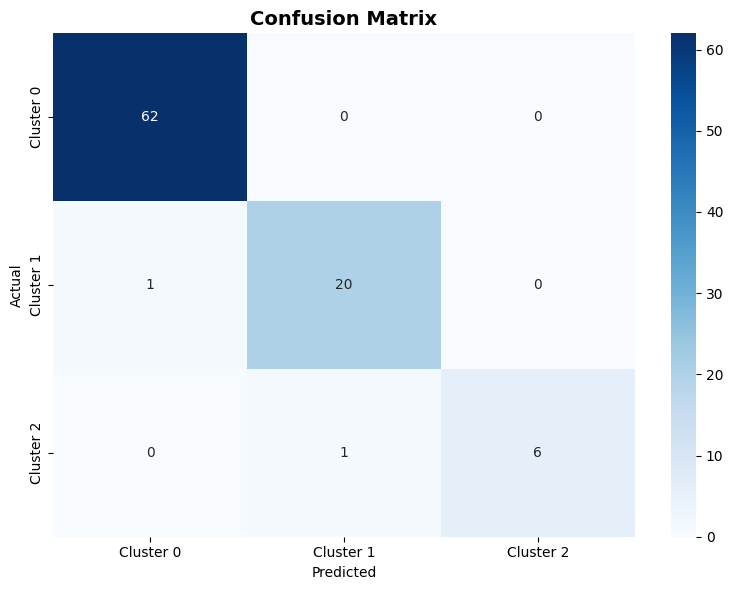

In [10]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()


In [11]:
os.makedirs('models', exist_ok=True)

with open('models/sentinel2_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)
with open('models/sentinel2_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
df_clean.to_csv('models/sentinel2_data.csv', index=False)

print(f"Saved: models/sentinel2_model.pkl ({best_name}), models/sentinel2_scaler.pkl, models/sentinel2_data.csv")


Saved: models/sentinel2_model.pkl (Random Forest), models/sentinel2_scaler.pkl, models/sentinel2_data.csv


## Summary

**Objective:** Optical satellite analysis for glacier mapping using vegetation and snow indices

**Study Area:** Gangotri Glacier, Uttarakhand Himalayas (30.92°N, 79.08°E)

**Data Sources:**
- Sentinel-2 MSI (2018-2019, 2022-2023): 10-20m resolution, Level-2A surface reflectance
- Bands: B3 (Green), B4 (Red), B8 (NIR), B11 (SWIR)
- Cloud filtering: < 80% cloud cover

**Methodology:**
- Feature extraction: NDVI, NDSI for both periods
- Derived features: Multi-temporal change in NDVI and NDSI
- Classification: 3-class unsupervised clustering (K-Means)
- Models: Random Forest, SVM, KNN with class balancing
- Validation: 70/30 train-test split

**Outputs:**
- Trained model: `models/sentinel2_model.pkl`
- Feature scaler: `models/sentinel2_scaler.pkl`
- Classification data: `models/sentinel2_data.csv`
